In [1]:
import re
import csv
import sys
import numpy as np
import pandas as pd
from pprint import pprint
import pickle

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Helper functions

In [2]:
pd.options.display.max_columns = 100

In [4]:
def pickle_file(object_to_save, filepath):
    with open(filepath, 'wb') as fp:
        pickle.dump(object_to_save, fp)

def load_pickle_file(filepath) :
    with open(filepath, "rb") as fp: 
        rv = pickle.load(fp)
    return rv

In [5]:
csv.field_size_limit(sys.maxsize)
df_review = pd.read_csv('Seattle/individual_review_inspection_merged.csv', sep=None,engine='python')
# df_merged = pd.read_csv('Seattle/instances_mergerd_seattle.csv', sep=None,engine='python')
# df_LA = pd.read_csv('LA_reviews.csv')

In [6]:
print(df_review.shape)
#print(df_merged.shape)

(162310, 21)


In [7]:
# Seattle
df = df_review[['inspection_id','restaurant_id','review_id','inspection_penalty_score', 'rating', 'content']]

In [8]:
# LA
# df_LA = df_LA[df_LA.categories.notnull()]
# df_LA_restaurants = df_LA[df_LA['categories'].str.contains('Restaurants')]
# df = df_LA_restaurants[['review_id','business_id','stars', 'text']]
# df.stars = pd.to_numeric(df.stars, errors='coerce')

In [9]:
df.shape

(162310, 6)

In [10]:
# create training set texts
negative = df[df.rating == 1]

In [11]:
print(negative.shape)
pprint(negative.restaurant_id.value_counts()[:5])

(9378, 6)
Y5r2AvXmSc-YA6MGXjK6Ow    144
fm3gYcYBaHcO9HlkPFN5kA     69
tWzPbuaUwhjkjIqE0YE4dA     58
y3apOqnMuG-FMaRox5jKpg     57
__KJyEXGAQRaBhZm3yto2g     56
Name: restaurant_id, dtype: int64


In [12]:
negative.head()

,inspection_id,restaurant_id,review_id,inspection_penalty_score,rating,content
29,DAWE0JV4G,SgK8qSSDYakUVa8WUbE33w,review__pdU_nF_4dXzyAaKxF6V8w,0,1.0,"First off, let me say this is my first yelp re..."
54,DA2108065,SgK8qSSDYakUVa8WUbE33w,review_B_TQfExWhMwkEsFY8VUgMQ,0,1.0,I decided to try this place again. They can't ...
55,DA2108065,SgK8qSSDYakUVa8WUbE33w,review__aXcMxJmvUdv2B_j6jztRQ,0,1.0,Happened upon this place via Groupon. &#160;Le...
77,DA2411831,jJp7BaSZ4eu0MfqkZjuJGw,review_W00YVuQjW0qKLjnVyx4zIg,45,1.0,This was my first and last time at this restur...
83,DA2411832,jJp7BaSZ4eu0MfqkZjuJGw,review_W00YVuQjW0qKLjnVyx4zIg,70,1.0,This was my first and last time at this restur...


## Tokenize Words and Clean-up Text

In [13]:
data = df.content.values.tolist()
pprint(data[:1])

['We went here this past weekend with zero expectations of what we would find. '
 'What we had really blew us away: FABULOUS food, big portions, and very '
 'friendly service. The decor was lacking, but we did not even notice it once '
 'we dug into our yummy food. Everyone in our group ordered something '
 'different and all got rave reviews. I had the tofu asparagus, and the '
 'veggies were all super fresh, not overcooked and the tofu was really cooked '
 'prefectly. This will be an addition to our regular rotation of great places '
 'to eat in WS!PS - one of our friends said the food alone was worth the drive '
 'to West Seattle...and he is from Issaquah!']


In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [15]:
print(data_words[:1])

[['we', 'went', 'here', 'this', 'past', 'weekend', 'with', 'zero', 'expectations', 'of', 'what', 'we', 'would', 'find', 'what', 'we', 'had', 'really', 'blew', 'us', 'away', 'fabulous', 'food', 'big', 'portions', 'and', 'very', 'friendly', 'service', 'the', 'decor', 'was', 'lacking', 'but', 'we', 'did', 'not', 'even', 'notice', 'it', 'once', 'we', 'dug', 'into', 'our', 'yummy', 'food', 'everyone', 'in', 'our', 'group', 'ordered', 'something', 'different', 'and', 'all', 'got', 'rave', 'reviews', 'had', 'the', 'tofu', 'asparagus', 'and', 'the', 'veggies', 'were', 'all', 'super', 'fresh', 'not', 'overcooked', 'and', 'the', 'tofu', 'was', 'really', 'cooked', 'prefectly', 'this', 'will', 'be', 'an', 'addition', 'to', 'our', 'regular', 'rotation', 'of', 'great', 'places', 'to', 'eat', 'in', 'ws', 'ps', 'one', 'of', 'our', 'friends', 'said', 'the', 'food', 'alone', 'was', 'worth', 'the', 'drive', 'to', 'west', 'seattle', 'and', 'he', 'is', 'from', 'issaquah']]


## Creating Bigram and Trigram Models

In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=100) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

### Remove Stopwords, Make Bigrams and Lemmatize

In [17]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['&#160;'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [19]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [22]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

In [24]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

# Save lemmatized data if necessary
# pickle_file(data_lemmatized, 'data_lemmatized')

[['go', 'past', 'weekend', 'expectation', 'would', 'find', 'really', 'blow', 'away', 'fabulous', 'food', 'big', 'portion', 'friendly', 'service', 'decor', 'lack', 'even', 'notice', 'dig', 'yummy', 'food', 'everyone', 'group', 'order', 'something', 'different', 'get', 'rave', 'review', 'tofu', 'asparagus', 'veggie', 'super', 'fresh', 'overcook', 'tofu', 'really', 'cook', 'prefectly', 'addition', 'regular', 'rotation', 'great', 'place', 'eat', 'friend', 'say', 'food', 'alone', 'worth', 'drive', 'west', 'seattle', 'issaquah']]


## Create the Dictionary and Corpus needed for Topic Modeling

In [25]:
# Option1: Create New Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Filter extreme tokens if necessary
# id2word.filter_extremes(no_below=3, no_above=0.5)
# id2word.compactify()

# Option2: Load existing dictionary
# id2word_load = corpora.Dictionary.load("Seattle/lda_seattle.id2word")

In [27]:
# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Save if necessary 
# pickle_file(corpus, 'corpus_all')

# Human readable format of corpus (term-frequency)
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 3), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)]]


## Building the Topic Model

In [28]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
#                                           update_every=1,
#                                           chunksize=100,
#                                           passes=10,
#                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [29]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics(num_topics=20))

[(0,
  '0.021*"tutta_bella" + 0.017*"table" + 0.013*"room" + 0.012*"music" + '
  '0.011*"night" + 0.010*"feel" + 0.010*"dining" + 0.010*"party" + '
  '0.009*"experience" + 0.009*"space"'),
 (1,
  '0.112*"pizza" + 0.055*"sandwich" + 0.026*"salad" + 0.024*"good" + '
  '0.017*"crust" + 0.016*"bread" + 0.014*"cheese" + 0.011*"slice" + '
  '0.010*"get" + 0.010*"fresh"'),
 (2,
  '0.029*"place" + 0.013*"get" + 0.011*"seattle" + 0.010*"go" + 0.009*"make" + '
  '0.008*"find" + 0.008*"people" + 0.008*"street" + 0.008*"walk" + '
  '0.007*"know"'),
 (3,
  '0.092*"cheese" + 0.023*"mac" + 0.019*"goat" + 0.015*"thin_crust" + '
  '0.014*"blue" + 0.012*"good" + 0.008*"get" + 0.007*"margarita" + '
  '0.007*"pepperoni" + 0.006*"try"'),
 (4,
  '0.148*"burger" + 0.060*"fry" + 0.039*"amp" + 0.026*"bacon" + 0.014*"shake" '
  '+ 0.012*"red_mill" + 0.011*"onion_ring" + 0.010*"bun" + 0.010*"ivar" + '
  '0.010*"good"'),
 (5,
  '0.039*"good" + 0.021*"get" + 0.017*"pretty" + 0.016*"place" + '
  '0.015*"really" + 0

In [30]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.68567387317


KeyboardInterrupt: 

In [45]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq/backend/cython/message.c:4018)
KeyboardInterrupt


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
16     13.630535        1       1  0.101878  0.032979
8      13.406019        1       2  0.152887 -0.067343
7       8.475261        1       3  0.017579  0.178863
5       7.575706        1       4 -0.031124  0.028158
9       6.887346        1       5  0.139605 -0.132405
14      6.645020        1       6  0.140112  0.074791
6       5.964071        1       7  0.097721  0.071877
12      5.619729        1       8 -0.112132  0.135408
2       5.590658        1       9  0.102114 -0.154615
11      3.956983        1      10 -0.025730  0.044677
1       3.613051        1      11 -0.097548  0.065670
0       3.467910        1      12  0.211402  0.054492
10      2.760649        1      13 -0.066688  0.006059
17      2.478081        1      14 -0.134350  0.079492
18      1.998760        1      15 -0.068334  0.119133
15      1.989725        1      16  0.109697 -0.088572
4       1.748872        1      17 -0.166547 -0.142684
13      1.461567        1      18 -0.183899 -0.073924
3       1.385583        1      19 -0.066824 -0.067259
19      1.344476        1      20 -0.119820 -0.164795, topic_info=      Category           Freq       Term          Total  loglift  logprob
term                                                                     
41     Default   37985.000000      pizza   37985.000000  30.0000  30.0000
16928  Default   24207.000000     burger   24207.000000  29.0000  29.0000
58631  Default   22193.000000     cheese   22193.000000  28.0000  28.0000
10658  Default   24520.000000        fry   24520.000000  27.0000  27.0000
50500  Default   20313.000000   sandwich   20313.000000  26.0000  26.0000
11367  Default   31432.000000      drink   31432.000000  25.0000  25.0000
61046  Default   29278.000000    chicken   29278.000000  24.0000  24.0000
11638  Default   27370.000000       hour   27370.000000  23.0000  23.0000
35111  Default  163586.000000       good  163586.000000  22.0000  22.0000
75977  Default   27668.000000      happy   27668.000000  21.0000  21.0000
52313  Default   25818.000000        bar   25818.000000  20.0000  20.0000
43688  Default   19208.000000       beer   19208.000000  19.0000  19.0000
46984  Default   13450.000000       roll   13450.000000  18.0000  18.0000
38434  Default  124327.000000      place  124327.000000  17.0000  17.0000
79238  Default  120819.000000       food  120819.000000  16.0000  16.0000
47498  Default   74656.000000      great   74656.000000  15.0000  15.0000
42295  Default    9625.000000       thai    9625.000000  14.0000  14.0000
2130   Default   12001.000000     coffee   12001.000000  13.0000  13.0000
38377  Default   23528.000000      salad   23528.000000  12.0000  12.0000
49581  Default   12630.000000       fish   12630.000000  11.0000  11.0000
10106  Default    8889.000000       chip    8889.000000  10.0000  10.0000
42717  Default   26034.000000      sauce   26034.000000   9.0000   9.0000
17164  Default    9374.000000      sushi    9374.000000   8.0000   8.0000
69922  Default   28601.000000       dish   28601.000000   7.0000   7.0000
6683   Default   13461.000000       soup   13461.000000   6.0000   6.0000
70357  Default   10879.000000     noodle   10879.000000   5.0000   5.0000
25263  Default   10685.000000  breakfast   10685.000000   4.0000   4.0000
8654   Default   13781.000000        amp   13781.000000   3.0000   3.0000
62964  Default   32137.000000       wait   32137.000000   2.0000   2.0000
36649  Default   71670.000000      order   71670.000000   1.0000   1.0000
...        ...            ...        ...            ...      ...      ...
56633  Topic20     152.683767      smash     153.665645   4.3028  -6.7156
29512  Topic20    1772.244634         be    1784.706067   4.3022  -4.2640
35090  Topic20    6218.481820        not    6394.126186   4.2813  -3.0087
65952  Topic20     524.697449       will     529.151041   4.3007  -5.4812
63679  Topic20     463.070368  

In [25]:
# Remember to save model
lda_model.save('lda_negative')

## Mallet-LDA Implementation

In [113]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=40, id2word=id2word)

In [114]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()


[(30,
  [('breakfast', 0.063101192766448627),
   ('egg', 0.049249711427472108),
   ('coffee', 0.039534436321662175),
   ('bacon', 0.030300115429011159),
   ('eat', 0.023662947287418239),
   ('potato', 0.018949595998460946),
   ('meal', 0.017602924201616008),
   ('pancake', 0.017218160831088881),
   ('morning', 0.016352443247402846),
   ('hard', 0.01596767987687572)]),
 (18,
  [('place', 0.14010378057820608),
   ('review', 0.12796515937731653),
   ('food', 0.051056338028169015),
   ('good', 0.049666419570051891),
   ('yelp', 0.036137879911045216),
   ('write', 0.027891030392883619),
   ('read', 0.026686434395848776),
   ('great', 0.025018532246108227),
   ('find', 0.019458858413639733),
   ('hear', 0.016493699036323202)]),
 (31,
  [('good', 0.1885119855269109),
   ('place', 0.14201718679330619),
   ('pretty', 0.082406151062867486),
   ('thing', 0.058435097241067394),
   ('food', 0.029488919041157847),
   ('kind', 0.028222523744911805),
   ('bbq', 0.024242424242424242),
   ('guess', 0.02

## Find Optimal Number of Topics

In [74]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [119]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

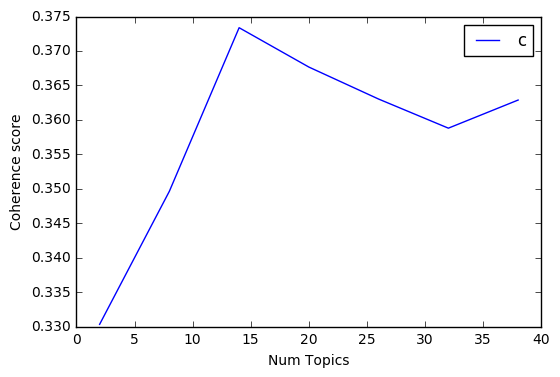

In [120]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [121]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3303
Num Topics = 8  has Coherence Value of 0.3496
Num Topics = 14  has Coherence Value of 0.3734
Num Topics = 20  has Coherence Value of 0.3677
Num Topics = 26  has Coherence Value of 0.363
Num Topics = 32  has Coherence Value of 0.3588
Num Topics = 38  has Coherence Value of 0.3629


In [122]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.051*"great" + 0.048*"food" + 0.035*"good" + 0.034*"place" + '
  '0.023*"service" + 0.018*"love" + 0.015*"seattle" + 0.014*"friendly" + '
  '0.014*"go" + 0.014*"always"'),
 (1,
  '0.012*"go" + 0.012*"know" + 0.011*"place" + 0.010*"make" + 0.010*"food" + '
  '0.010*"people" + 0.007*"say" + 0.007*"time" + 0.007*"see" + 0.007*"work"'),
 (2,
  '0.023*"get" + 0.021*"place" + 0.020*"go" + 0.015*"good" + 0.013*"order" + '
  '0.013*"wait" + 0.012*"come" + 0.012*"time" + 0.010*"try" + 0.009*"back"'),
 (3,
  '0.022*"wine" + 0.012*"dessert" + 0.009*"restaurant" + 0.009*"night" + '
  '0.009*"dinner" + 0.008*"service" + 0.007*"server" + 0.007*"course" + '
  '0.007*"marrow" + 0.007*"evening"'),
 (4,
  '0.021*"good" + 0.018*"place" + 0.012*"restaurant" + 0.011*"noodle" + '
  '0.010*"get" + 0.010*"dish" + 0.010*"order" + 0.010*"meat" + 0.009*"food" + '
  '0.009*"go"'),
 (5,
  '0.068*"pizza" + 0.032*"good" + 0.016*"cheese" + 0.016*"get" + 0.014*"crust" '
  '+ 0.012*"place" + 0.010*"sauce" + 0.

## Apply two models to all review texts

In [41]:
lda_negative = gensim.models.ldamodel.LdaModel.load('lda_negative', mmap='r')
lda_positive = gensim.models.ldamodel.LdaModel.load('lda_positive', mmap='r')

In [77]:
id2word_negative = corpora.Dictionary.load("lda_negative.id2word")
id2word_positive = corpora.Dictionary.load("lda_positive.id2word")

In [90]:
def get_topic_prob(new_texts, lda_model, id2word, prefix, num_columns=21):
    corpus = [id2word.doc2bow(text) for text in new_texts]
    
    columns = list(range(0,num_columns))
    df_topic_prob = pd.DataFrame(columns=columns)
    for review in corpus:
        topic_prob = [0] * num_columns
        highest_prob = 0
        dominant_topic = 0
        for item in lda_model.get_document_topics(review):
            topic, prob = item[0], item[1]
            topic_prob[topic] = prob
            if prob > highest_prob:
                dominant_topic = topic
                highest_prob = prob
        topic_prob[-1] = dominant_topic
        df_topic_prob = df_topic_prob.append(pd.Series(topic_prob),ignore_index=True)
    for i in range(20):
        df_topic_prob = df_topic_prob.rename(columns = {i: prefix + '_' + str(i)})
    df_topic_prob = df_topic_prob.rename(columns = {20:prefix + '_' + 'dominant_topic'})
    return df_topic_prob

In [ ]:
# Do it in terminal 
negative_prob = get_topic_prob(data_lemmatized, lda_negative, id2word_negative, 'negative_topic')
positive_prob = get_topic_prob(data_lemmatized, lda_positive, id2word_positive, 'positive_topic')

In [102]:
# Some experiments.
get_topic_prob(data_lemmatized[:20], lda_positive, id2word_positive, 'positive_topic')

,positive_topic_0,positive_topic_1,positive_topic_2,positive_topic_3,positive_topic_4,positive_topic_5,positive_topic_6,positive_topic_7,positive_topic_8,positive_topic_9,positive_topic_10,positive_topic_11,positive_topic_12,positive_topic_13,positive_topic_14,positive_topic_15,positive_topic_16,positive_topic_17,positive_topic_18,positive_topic_19,positive_topic_dominant_topic
0,0.000000,0.106791,0.000000,0.000000,0.000000,0.000000,0.000000,0.208206,0.000000,0.000000,0.000000,0.000000,0.668657,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.0
1,0.233266,0.176836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054218,0.503680,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.0
2,0.748387,0.000000,0.000000,0.000000,0.176613,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.437896,0.000000,0.000000,0.000000,0.259242,0.000000,0.211560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053207,0.000000,0.000000,0.0
4,0.412797,0.000000,0.206160,0.000000,0.231159,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043339,0.081545,0.000000,0.0
5,0.000000,0.168199,0.090332,0.000000,0.126307,0.000000,0.060179,0.047946,0.000000,0.010391,0.000000,0.074049,0.211666,0.068797,0.047742,0.000000,0.000000,0.000000,0.091729,0.000000,12.0
6,0.204924,0.109811,0.315022,0.000000,0.145583,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.107909,0.000000,0.061309,0.045884,2.0
7,0.000000,0.366180,0.221326,0.022671,0.049922,0.000000,0.000000,0.000000,0.035565,0.000000,0.000000,0.000000,0.100892,0.042976,0.115782,0.000000,0.000000,0.000000,0.038061,0.000000,1.0
8,0.553355,0.000000,0.000000,0.000000,0.132542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.096765,0.000000,0.198734,0.000000,0.000000,0.000000,0.0
9,0.000000,0.000000,0.070291,0.000000,0.083614,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.586937,0.000000,0.000000,0.000000,0.168181,0.000000,0.083968,0.000000,12.0


In [105]:
data[18]

"i recently ate here....next time you'll have to order two meals....one for me and one for the person holding the gun to my head.....i ordered the spicy beef teriyaki.....the beef was cut into huge big blocks,nor was it tender. it took them twenty plus minutes to get the food out. but........but on a good note the sauce was hot. i will be going around the corner to niko's teriyaki in the future."

In [95]:
pprint(lda_positive.print_topics(num_words=10))

[(0,
  '0.053*"great" + 0.048*"good" + 0.047*"food" + 0.043*"place" + '
  '0.026*"service" + 0.022*"seattle" + 0.019*"price" + 0.016*"always" + '
  '0.015*"friendly" + 0.015*"love"'),
 (1,
  '0.014*"go" + 0.013*"know" + 0.013*"make" + 0.010*"people" + 0.009*"place" + '
  '0.008*"get" + 0.008*"time" + 0.007*"see" + 0.007*"food" + 0.007*"say"'),
 (2,
  '0.021*"get" + 0.017*"go" + 0.017*"place" + 0.016*"wait" + 0.015*"order" + '
  '0.013*"come" + 0.012*"good" + 0.011*"table" + 0.011*"time" + 0.010*"back"'),
 (3,
  '0.029*"drink" + 0.027*"cocktail" + 0.017*"bartender" + 0.016*"bar" + '
  '0.011*"wine" + 0.008*"menu" + 0.006*"bottle" + 0.006*"glass" + 0.006*"beer" '
  '+ 0.006*"selection"'),
 (4,
  '0.040*"sushi" + 0.024*"fish" + 0.018*"good" + 0.016*"roll" + 0.015*"place" '
  '+ 0.013*"fresh" + 0.011*"macaron" + 0.011*"salmon" + 0.011*"japanese" + '
  '0.009*"go"'),
 (5,
  '0.113*"pizza" + 0.028*"good" + 0.020*"crust" + 0.013*"sauce" + '
  '0.012*"place" + 0.012*"get" + 0.012*"salad" + 0.0

In [103]:
get_topic_prob(data_lemmatized[:20], lda_negative, id2word_negative, 'negative_topic')

,negative_topic_0,negative_topic_1,negative_topic_2,negative_topic_3,negative_topic_4,negative_topic_5,negative_topic_6,negative_topic_7,negative_topic_8,negative_topic_9,negative_topic_10,negative_topic_11,negative_topic_12,negative_topic_13,negative_topic_14,negative_topic_15,negative_topic_16,negative_topic_17,negative_topic_18,negative_topic_19,negative_topic_dominant_topic
0,0.000000,0.068597,0.000000,0.128006,0.000000,0.000000,0.185310,0.000000,0.000000,0.000000,0.551760,0.000000,0.000000,0.000000,0.000000,0.000000,0.052176,0.000000,0.000000,0.000000,10.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.602884,0.103171,0.220782,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043533,0.000000,0.000000,0.000000,0.000000,5.0
2,0.000000,0.000000,0.000000,0.182859,0.000000,0.000000,0.000000,0.468725,0.283031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.405285,0.551857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.0
4,0.000000,0.000000,0.000000,0.125104,0.000000,0.647130,0.000000,0.000000,0.085362,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052106,0.000000,0.065298,0.000000,0.000000,5.0
5,0.032246,0.052081,0.000000,0.071652,0.021589,0.274393,0.019256,0.181271,0.256692,0.000000,0.000000,0.000000,0.057946,0.000000,0.000000,0.014948,0.000000,0.000000,0.000000,0.015231,5.0
6,0.000000,0.000000,0.000000,0.117376,0.000000,0.000000,0.000000,0.244429,0.107726,0.155566,0.120125,0.000000,0.083224,0.089690,0.073039,0.000000,0.000000,0.000000,0.000000,0.000000,7.0
7,0.000000,0.105288,0.000000,0.000000,0.081142,0.298298,0.000000,0.163068,0.000000,0.057971,0.062003,0.000000,0.000000,0.000000,0.206803,0.000000,0.000000,0.018198,0.000000,0.000000,5.0
8,0.000000,0.000000,0.000000,0.301877,0.000000,0.000000,0.000000,0.000000,0.213690,0.000000,0.465544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.0
9,0.086561,0.000000,0.085627,0.000000,0.000000,0.069558,0.032532,0.300579,0.000000,0.175853,0.200263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043366,0.000000,7.0


In [101]:
df.head(20)

,inspection_id,restaurant_id,review_id,inspection_penalty_score,rating,content
0,DA2383404,ZriNDCVxkCdVEO-X2sjHFw,review_Q9_9A9QmmpX4unYRcEQc8g,0,5.0,We went here this past weekend with zero expec...
1,DA2304227,ZriNDCVxkCdVEO-X2sjHFw,review_IveKyEloRTk8bHJ8xcpalA,0,4.0,Lots of young families . Kind of sparse &#160;...
2,DA2304227,ZriNDCVxkCdVEO-X2sjHFw,review_1pIZlx4k7U8S-_dX-kzb4w,0,4.0,Our favorite teriyaki in West Seattle! Generou...
3,DA2304227,ZriNDCVxkCdVEO-X2sjHFw,review_iaieVt5Tm_US0LTsHMSC6Q,0,4.0,Seattle has a lot of great teriyaki. &#160;Thi...
4,DA2278690,ZriNDCVxkCdVEO-X2sjHFw,review_WxjHfhYRD3heTI6ETb7sdg,40,4.0,This place is a gem! My husband and I didn't h...
5,DA2278690,ZriNDCVxkCdVEO-X2sjHFw,review_zTunv8SyK5YngBzFEvGQMw,40,5.0,"Looks like a dive, tastes divine! I wish someo..."
6,DA2278690,ZriNDCVxkCdVEO-X2sjHFw,review_18oexJSjrbelG1IFx-xC_g,40,4.0,I thought I walked into a two lane bowling all...
7,DA2278690,ZriNDCVxkCdVEO-X2sjHFw,review_GO-sVPYCwt0nAG6sINz2hg,40,4.0,You know- sometimes (especially if you spend a...
8,DA2278690,ZriNDCVxkCdVEO-X2sjHFw,review_IgpSP4MK3kzzeYVdrkbhvg,40,5.0,Best Teriyaki In West Seattle! &#160;Food is f...
9,DA2278690,ZriNDCVxkCdVEO-X2sjHFw,review_j1_13Ca62XLQlkDCVo2dfw,40,5.0,"I didn't initially want to eat here, because a..."


In [99]:
pprint(lda_negative.print_topics(num_words=10))

[(0,
  '0.021*"food" + 0.017*"go" + 0.014*"good" + 0.012*"bad" + 0.010*"taste" + '
  '0.010*"get" + 0.008*"terrible" + 0.008*"service" + 0.007*"restaurant" + '
  '0.007*"eat"'),
 (1,
  '0.014*"go" + 0.010*"food" + 0.009*"place" + 0.008*"make" + 0.008*"get" + '
  '0.007*"would" + 0.007*"good" + 0.007*"think" + 0.006*"people" + '
  '0.006*"drink"'),
 (2,
  '0.028*"order" + 0.016*"come" + 0.015*"get" + 0.014*"go" + 0.013*"food" + '
  '0.013*"say" + 0.012*"take" + 0.012*"ask" + 0.012*"tell" + 0.011*"minute"'),
 (3,
  '0.016*"sandwich" + 0.014*"food" + 0.014*"go" + 0.010*"order" + '
  '0.010*"place" + 0.009*"say" + 0.008*"noodle" + 0.008*"dish" + 0.007*"would" '
  '+ 0.007*"chicken"'),
 (4,
  '0.012*"really" + 0.012*"get" + 0.011*"food" + 0.011*"place" + 0.010*"go" + '
  '0.010*"time" + 0.010*"order" + 0.009*"good" + 0.008*"people" + '
  '0.007*"wait"'),
 (5,
  '0.022*"service" + 0.019*"place" + 0.017*"food" + 0.017*"good" + 0.013*"get" '
  '+ 0.012*"go" + 0.009*"come" + 0.009*"time" + 0.00

## Merge DF & Save files

In [37]:
df.iloc[:,:-1].head()

,inspection_id,restaurant_id,review_id,inspection_penalty_score,rating
0,DA2383404,ZriNDCVxkCdVEO-X2sjHFw,review_Q9_9A9QmmpX4unYRcEQc8g,0,5.0
1,DA2304227,ZriNDCVxkCdVEO-X2sjHFw,review_IveKyEloRTk8bHJ8xcpalA,0,4.0
2,DA2304227,ZriNDCVxkCdVEO-X2sjHFw,review_1pIZlx4k7U8S-_dX-kzb4w,0,4.0
3,DA2304227,ZriNDCVxkCdVEO-X2sjHFw,review_iaieVt5Tm_US0LTsHMSC6Q,0,4.0
4,DA2278690,ZriNDCVxkCdVEO-X2sjHFw,review_WxjHfhYRD3heTI6ETb7sdg,40,4.0


In [40]:
positive_prob = pd.read_csv('positive_prob_seattle.csv', index_col=0)
negative_prob = pd.read_csv('negative_prob_seattle.csv', index_col=0)

In [42]:
df_merged = pd.concat([df.iloc[:,:-1],positive_prob, negative_prob], axis=1)

In [43]:
df_merged.to_csv('review_topic_model_seattle.csv')

In [44]:
df_merged.head()

,inspection_id,restaurant_id,review_id,inspection_penalty_score,rating,positive_topic_0,positive_topic_1,positive_topic_2,positive_topic_3,positive_topic_4,positive_topic_5,positive_topic_6,positive_topic_7,positive_topic_8,positive_topic_9,positive_topic_10,positive_topic_11,positive_topic_12,positive_topic_13,positive_topic_14,positive_topic_15,positive_topic_16,positive_topic_17,positive_topic_18,positive_topic_19,positive_topic_dominant_topic,negative_topic_0,negative_topic_1,negative_topic_2,negative_topic_3,negative_topic_4,negative_topic_5,negative_topic_6,negative_topic_7,negative_topic_8,negative_topic_9,negative_topic_10,negative_topic_11,negative_topic_12,negative_topic_13,negative_topic_14,negative_topic_15,negative_topic_16,negative_topic_17,negative_topic_18,negative_topic_19,negative_topic_dominant_topic
0,DA2383404,ZriNDCVxkCdVEO-X2sjHFw,review_Q9_9A9QmmpX4unYRcEQc8g,0,5.0,0.000000,0.100246,0.022901,0.0,0.000000,0.0,0.000000,0.208407,0.0,0.0,0.0,0.000000,0.653061,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,12.0,0.0,0.068678,0.0,0.127851,0.0,0.000000,0.185621,0.000000,0.000000,0.0,0.55152,0.0,0.0,0.00000,0.0,0.000000,0.052179,0.000000,0.0,0.000000,10.0
1,DA2304227,ZriNDCVxkCdVEO-X2sjHFw,review_IveKyEloRTk8bHJ8xcpalA,0,4.0,0.233346,0.176747,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.054219,0.503688,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,12.0,0.0,0.000000,0.0,0.000000,0.0,0.599972,0.103377,0.223473,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.0,0.043549,0.000000,0.000000,0.0,0.000000,5.0
2,DA2304227,ZriNDCVxkCdVEO-X2sjHFw,review_1pIZlx4k7U8S-_dX-kzb4w,0,4.0,0.748128,0.000000,0.000000,0.0,0.176872,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.182750,0.0,0.000000,0.000000,0.468379,0.283486,0.0,0.00000,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,7.0
3,DA2304227,ZriNDCVxkCdVEO-X2sjHFw,review_iaieVt5Tm_US0LTsHMSC6Q,0,4.0,0.435826,0.083181,0.000000,0.0,0.245486,0.0,0.148079,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.051715,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.405391,0.551751,0.0,0.00000,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,8.0
4,DA2278690,ZriNDCVxkCdVEO-X2sjHFw,review_WxjHfhYRD3heTI6ETb7sdg,40,4.0,0.412775,0.000000,0.206134,0.0,0.231176,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.043339,0.081576,0.0,0.0,0.0,0.000000,0.0,0.109880,0.0,0.718097,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.04746,0.0,0.000000,0.000000,0.063372,0.0,0.036191,5.0


## Find the most representative document for each topic

In [122]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5713,"taste, buffet, good, small, rice, eat, fish, d...",We were pretty excited when the signs for Inak...
1,1.0,0.5799,"food, place, bad, eat, service, give, star, ti...",Wir waren dieses Jahr zum zweiten Mal in Vegas...
2,2.0,0.6040,"people, night, line, room, open, pay, hotel, s...",On 28 June 2013 I checked into the Riviera Hot...
3,3.0,0.6335,"good, place, food, price, pretty, vegas, great...","Ayer estuve en este restaurante, yo no lo cono..."
4,4.0,0.4718,"order, chicken, fry, pizza, burger, taste, sau...",I had the trio of sliders for $ 7 \n. The barb...


In [125]:
pprint(sent_topics_sorteddf_mallet.Text.values.tolist())

["Average Teriyaki place on the Ave. &#160;If you're hungry and want a fairly "
 "large portion. &#160;This is the place to go but it's quantity over quality. "
 '&#160;The food is all right. &#160;Never been horrible but never been '
 'amazing either. &#160;Always worth a shot to try those other teriyaki places '
 'on the ave. &#160;There are so many.Nothing special and its usually crowded. '
 '&#160;A good bang for your buck.',
 'My general rule on ethnic restaurants is that you can tell how good it is '
 '&#160;based on how much of their clientele is of that ethnicity. &#160;Think '
 "of that what you will, but it's true. &#160;So when I came into this place "
 'in an aforementioned "grungy" part of town that looked like it belonged in '
 "Belltown, I got skeptical. &#160;But hey, at this point I didn't really "
 'care, I was hungry. &#160;And we were seated right away, which is a plus. '
 '&#160;And then they immediately gave us water and tea, which was another '
 'plus. &#160;Thin